<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Classification with LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.9.0+cu102].
device:[cuda:0].


### Dataset and Loader

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Done.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Define Model

In [3]:
class RecurrentNeuralNetworkClass(nn.Module):
    def __init__(self,name='rnn',xdim=28,hdim=256,ydim=10,n_layer=3):
        super(RecurrentNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdim = hdim
        self.ydim = ydim
        self.n_layer = n_layer # K

        self.rnn = nn.LSTM(
            input_size=self.xdim,hidden_size=self.hdim,num_layers=self.n_layer,batch_first=True)
        self.lin = nn.Linear(self.hdim,self.ydim)

    def forward(self,x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.n_layer,x.size(0),self.hdim).to(device)
        c0 = torch.zeros(self.n_layer,x.size(0),self.hdim).to(device)
        # RNN
        rnn_out,(hn,cn) = self.rnn(x, (h0,c0)) 
        # x:[N x L x Q] => rnn_out:[N x L x D]
        # Linear
        out = self.lin(rnn_out[:,-1 :]).view([-1,self.ydim]) # [N x K]
        return out 

R = RecurrentNeuralNetworkClass(
    name='rnn',xdim=28,hdim=256,ydim=10,n_layer=2).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(R.parameters(),lr=1e-3)
print ("Done.")

Done.


### Check How LSTM Works
- `N`: number of batches
- `L`: sequence lengh
- `Q`: input dim
- `K`: number of layers
- `D`: LSTM feature dimension

` Y,(hn,cn) = LSTM(X) `

- `X`: [N x L x Q] - `N` input sequnce of length `L` with `Q` dim. 
- `Y`: [N x L x D] - `N` output sequnce of length `L` with `D` feature dim.
- `hn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` feature dim. 
- `cn`: [K x N x D] - `K` (per each layer) of `N` final hidden state with  `D` cell dim. 

In [4]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,20,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out,(hn,cn) = R.rnn(x_torch) # forward path

print ("rnn_out:",rnn_out.shape) # [N x L x D]
print ("Hidden State hn:",hn.shape) # [K x N x D]
print ("Cell States cn:",cn.shape) # [K x N x D]

rnn_out: torch.Size([2, 20, 256])
Hidden State hn: torch.Size([2, 2, 256])
Cell States cn: torch.Size([2, 2, 256])


### Check parameters

In [5]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(R.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[rnn.weight_ih_l0] shape:[(1024, 28)].
    val:[ 0.048 -0.046  0.004  0.045  0.046]
[1] name:[rnn.weight_hh_l0] shape:[(1024, 256)].
    val:[ 0.046 -0.007 -0.04   0.034  0.025]
[2] name:[rnn.bias_ih_l0] shape:[(1024,)].
    val:[ 0.026  0.052  0.039  0.026 -0.032]
[3] name:[rnn.bias_hh_l0] shape:[(1024,)].
    val:[ 0.019  0.028 -0.014 -0.028 -0.059]
[4] name:[rnn.weight_ih_l1] shape:[(1024, 256)].
    val:[ 0.062 -0.042 -0.057 -0.027 -0.039]
[5] name:[rnn.weight_hh_l1] shape:[(1024, 256)].
    val:[-0.031 -0.002 -0.041 -0.036  0.04 ]
[6] name:[rnn.bias_ih_l1] shape:[(1024,)].
    val:[ 0.037  0.005 -0.014  0.041 -0.062]
[7] name:[rnn.bias_hh_l1] shape:[(1024,)].
    val:[-0.004 -0.051  0.051  0.04   0.023]
[8] name:[lin.weight] shape:[(10, 256)].
    val:[-0.03   0.01   0.037 -0.029  0.028]
[9] name:[lin.bias] shape:[(10,)].
    val:[0.049 0.018 0.015 0.029 0.053]
Total number of parameters:[821,770].


### Simple Forward Path 

In [6]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(3,10,28) # [N x L x Q]
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = R.forward(x_torch) # [N x 1 x R] where R is the output dim.
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
# print ("x_torch:\n",x_torch)
# print ("y_torch:\n",y_torch)
print ("x_numpy %s"%(x_numpy.shape,))
print ("y_numpy %s"%(y_numpy.shape,))

x_numpy (3, 10, 28)
y_numpy (3, 10)


### Evaluation Function

In [7]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.view(-1,28,28).to(device))
            _,y_pred = torch.max(model_pred,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [8]:
train_accr = func_eval(R,train_iter,device)
test_accr = func_eval(R,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.098] test_accr:[0.097].


### Train

In [9]:
print ("Start training.")
R.train() # to train mode 
EPOCHS,print_every = 5,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = R.forward(batch_in.view(-1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient 
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(R,train_iter,device)
        test_accr = func_eval(R,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.619] train_accr:[0.942] test_accr:[0.947].
epoch:[1] loss:[0.145] train_accr:[0.969] test_accr:[0.969].
epoch:[2] loss:[0.090] train_accr:[0.976] test_accr:[0.974].
epoch:[3] loss:[0.066] train_accr:[0.986] test_accr:[0.982].
epoch:[4] loss:[0.051] train_accr:[0.988] test_accr:[0.984].
Done


### Test

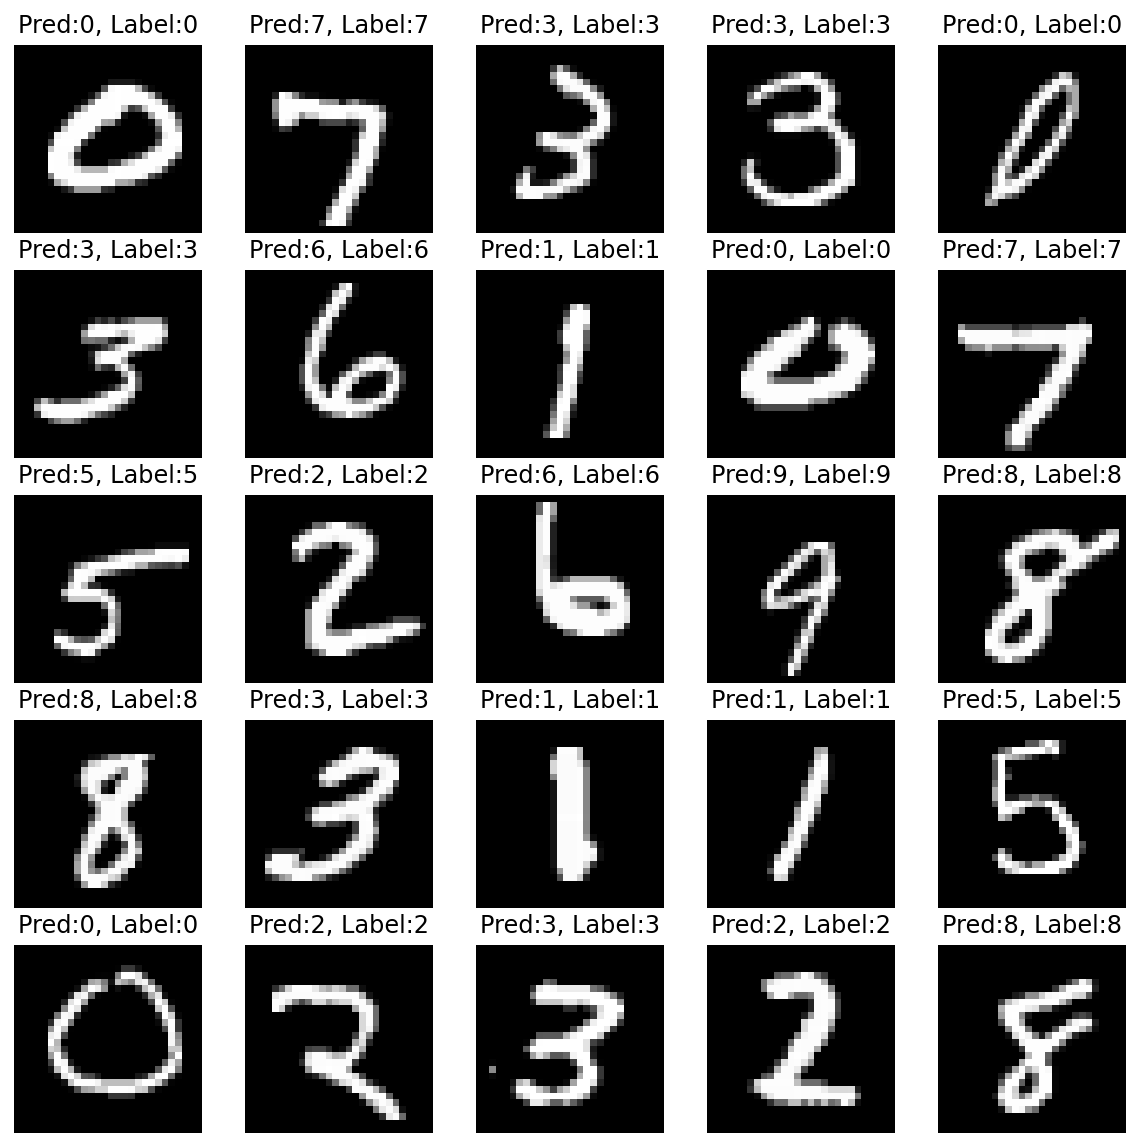

Done


In [10]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    R.eval() # to evaluation mode 
    y_pred = R.forward(test_x.view(-1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()
print ("Done")